# NOAA GEFS Basin Forecasts

This notebook extracts forecast data for each basin centroid from the NOAA GEFS 35-day forecast dataset and combines them into a single dataset with a unified structure.

## Overview

The process consists of the following steps:
1. Load basin centroid coordinates from a CSV file
2. Connect to the NOAA GEFS forecast dataset
3. Extract forecast data for each basin location using all available initialization times
4. Merge the individual basin forecasts into a combined dataset with dimensions: basin, time, lead_time, ensemble_member
5. Visualize and analyze the combined forecast data
6. Keep the dataset in memory for further processing

In [3]:
# Import required libraries
import os
import sys
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings

# Add src directory to path if it's not already in the path
if '../src' not in sys.path:
    sys.path.append('../src')
from fetch_basin_forecasts import (
    load_basin_centroids,
    fetch_forecasts_for_basins,
    interpolate_to_hourly,
    plot_basin_forecast,  # Import the new plotting function
)

# Suppress warnings
warnings.filterwarnings('ignore')

## Define Paths for Input and Output Data

In [4]:
# Define paths for input and output data
basin_centroids_file = "../data/basin_centroids.csv"  # File containing basin centroid coordinates
output_dir = "../data/basin_forecasts"  # Directory for output data (for plots only)

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

print(f"Basin centroids file: {basin_centroids_file}")

Basin centroids file: ../data/basin_centroids.csv


## Load Basin Centroids

Load the basin centroid coordinates from the CSV file.

In [5]:
# Load basin centroids
centroids = load_basin_centroids(basin_centroids_file)

# Display the basin coordinates
display(centroids)

Loaded 5 basin centroids from ../data/basin_centroids.csv


,basin_name,latitude,longitude
0,innerste_reservoir_catchment_Basin_0,51.834451,10.307828
1,oker_reservoir_catchment_Basin_0,51.816468,10.447276
2,ecker_reservoir_catchment_Basin_0,51.810056,10.584058
3,soese_reservoir_catchment_Basin_0,51.752310,10.383225
4,grane_reservoir_catchment_Basin_0,51.884391,10.357203


## Load NOAA GEFS Forecast Dataset

Connect to the online NOAA GEFS forecast dataset hosted by dynamical.org.

In [6]:
# Install dependencies if needed
# %pip install "xarray[complete]>=2025.1.2" "zarr>=3.0.4" requests aiohttp

In [7]:
# Load the NOAA GEFS forecast dataset
print("Loading NOAA GEFS dataset...")
ds = xr.open_zarr(
    "https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr?email=optional@email.com", 
    decode_timedelta=True
)

print("\nDataset summary:")
print(f"Time domain: {ds.attrs.get('time_domain', 'N/A')}")
print(f"Forecast domain: {ds.attrs.get('forecast_domain', 'N/A')}")
print(f"Spatial resolution: {ds.attrs.get('spatial_resolution', 'N/A')}")
print(f"\nDataset dimensions:")
for dim, size in ds.dims.items():
    print(f"  {dim}: {size}")

# Show the available initialization times (limited to last 10 for display)
init_times = pd.to_datetime(ds.init_time.values)
print(f"\nTotal number of initialization times: {len(init_times)}")
print(f"First initialization time: {init_times[0].strftime('%Y-%m-%d %H:%M')}")
print(f"Last initialization time: {init_times[-1].strftime('%Y-%m-%d %H:%M')}")
print("\nLatest 10 initialization times:")
for t in init_times[-10:]:
    print(f"  {t.strftime('%Y-%m-%d %H:%M')}")

Loading NOAA GEFS dataset...

Dataset summary:
Time domain: Forecasts initialized 2020-10-01 00:00:00 UTC to Present
Forecast domain: Forecast lead time 0-840 hours (0-35 days) ahead
Spatial resolution: 0-240 hours: 0.25 degrees (~20km), 243-840 hours: 0.5 degrees (~40km)

Dataset dimensions:
  init_time: 1657
  ensemble_member: 31
  lead_time: 181
  latitude: 721
  longitude: 1440

Total number of initialization times: 1657
First initialization time: 2020-10-01 00:00
Last initialization time: 2025-04-14 00:00

Latest 10 initialization times:
  2025-04-05 00:00
  2025-04-06 00:00
  2025-04-07 00:00
  2025-04-08 00:00
  2025-04-09 00:00
  2025-04-10 00:00
  2025-04-11 00:00
  2025-04-12 00:00
  2025-04-13 00:00
  2025-04-14 00:00

Dataset summary:
Time domain: Forecasts initialized 2020-10-01 00:00:00 UTC to Present
Forecast domain: Forecast lead time 0-840 hours (0-35 days) ahead
Spatial resolution: 0-240 hours: 0.25 degrees (~20km), 243-840 hours: 0.5 degrees (~40km)

Dataset dimensio

## Extract Forecasts for Basin Centroids

Extract the forecast data for each basin centroid location using all available initialization times.

In [8]:
# Option to limit the number of initialization times for testing or specific analysis
# Uncomment and modify the code below to use specific initialization times

# Use the most recent 5 initialization times to speed up processing
# recent_times = ds.init_time.values[-5:]
# ds_limited = ds.sel(init_time=recent_times)
# print(f"Limited analysis to the {len(recent_times)} most recent initialization times")

# Use all available initialization times for comprehensive analysis
# Set init_time to None to use all available times
init_time = None

# Extract forecasts for all basin centroids
basin_forecasts = fetch_forecasts_for_basins(ds, centroids, init_time)

# Check how many basin forecasts we've extracted
print(f"\nExtracted forecasts for {len(basin_forecasts)} basins")

Extracting forecasts for 5 basins...
Processing basin: innerste_reservoir_catchment_Basin_0 (lat: 51.8345, lon: 10.3078)
Processing basin: oker_reservoir_catchment_Basin_0 (lat: 51.8165, lon: 10.4473)
Processing basin: oker_reservoir_catchment_Basin_0 (lat: 51.8165, lon: 10.4473)
Processing basin: ecker_reservoir_catchment_Basin_0 (lat: 51.8101, lon: 10.5841)
Processing basin: ecker_reservoir_catchment_Basin_0 (lat: 51.8101, lon: 10.5841)
Processing basin: soese_reservoir_catchment_Basin_0 (lat: 51.7523, lon: 10.3832)
Processing basin: soese_reservoir_catchment_Basin_0 (lat: 51.7523, lon: 10.3832)
Processing basin: grane_reservoir_catchment_Basin_0 (lat: 51.8844, lon: 10.3572)
Processing basin: grane_reservoir_catchment_Basin_0 (lat: 51.8844, lon: 10.3572)
Successfully extracted forecasts for 5 basins
Dataset dimensions: {'basin': 5, 'init_time': 1657, 'ensemble_member': 31, 'lead_time': 181}

Extracted forecasts for 21 basins
Successfully extracted forecasts for 5 basins
Dataset dimen

In [9]:
basin_forecasts

<xarray.Dataset> Size: 4GB
Dimensions:                                     (basin: 5, init_time: 1657,
                                                 ensemble_member: 31,
                                                 lead_time: 181)
Coordinates:
  * ensemble_member                             (ensemble_member) uint16 62B ...
    expected_forecast_length                    (init_time) timedelta64[ns] 13kB dask.array<chunksize=(1657,), meta=np.ndarray>
    ingested_forecast_length                    (init_time, ensemble_member) timedelta64[ns] 411kB dask.array<chunksize=(1657, 31), meta=np.ndarray>
  * init_time                                   (init_time) datetime64[ns] 13kB ...
    latitude                                    (basin) float64 40B 51.75 ......
  * lead_time                                   (lead_time) timedelta64[ns] 1kB ...
    longitude                                   (basin) float64 40B 10.25 ......
    spatial_ref                                 int64 8B ...
    valid_time                                  (init_time, lead_time) datetime64[ns] 2MB dask.array<chunksize=(1657, 181), meta=np.ndarray>
  * basin                                       (basin) <U36 720B 'innerste_r...
Data variables: (12/21)
    categorical_freezing_rain_surface           (basin, init_time, ensemble_member, lead_time) float32 186MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    categorical_ice_pellets_surface             (basin, init_time, ensemble_member, lead_time) float32 186MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    categorical_rain_surface                    (basin, init_time, ensemble_member, lead_time) float32 186MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    categorical_snow_surface                    (basin, init_time, ensemble_member, lead_time) float32 186MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    downward_long_wave_radiation_flux_surface   (basin, init_time, ensemble_member, lead_time) float32 186MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    downward_short_wave_radiation_flux_surface  (basin, init_time, ensemble_member, lead_time) float32 186MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    ...                                          ...
    temperature_2m                              (basin, init_time, ensemble_member, lead_time) float32 186MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    total_cloud_cover_atmosphere                (basin, init_time, ensemble_member, lead_time) float32 186MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    wind_u_100m                                 (basin, init_time, ensemble_member, lead_time) float32 186MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    wind_u_10m                                  (basin, init_time, ensemble_member, lead_time) float32 186MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    wind_v_100m                                 (basin, init_time, ensemble_member, lead_time) float32 186MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    wind_v_10m                                  (basin, init_time, ensemble_member, lead_time) float32 186MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
Attributes:
    dataset_id:           noaa-gefs-forecast-35-day
    dataset_version:      0.2.0
    name:                 NOAA GEFS forecast, 35 day
    description:          Weather forecasts from the Global Ensemble Forecast...
    attribution:          NOAA NWS NCEP GEFS data processed by dynamical.org ...
    spatial_domain:       Global
    spatial_resolution:   0-240 hours: 0.25 degrees (~20km), 243-840 hours: 0...
    time_domain:          Forecasts initialized 2020-10-01 00:00:00 UTC to Pr...
    time_resolution:      Forecasts initialized every 24 hours.
    forecast_domain:      Forecast lead time 0-840 hours (0-35 days) ahead
    forecast_resolution:  Forecast step 0-240 hours: 3 hourly, 243-840 hours:...

## Interpolate to hourly values using linear interpolation

The NOAA GEFS forecast dataset provides data at varying temporal resolutions:
- For the first 240 hours (10 days): Data is available at 3-hour intervals
- For hours 243-840 (days 11-35): Data is available at 6-hour intervals

This results in 181 lead time steps over the 35-day forecast period:
- 81 steps for the first 10 days (0, 3, 6, ..., 240 hours)
- 100 steps for days 11-35 (243, 249, 255, ..., 840 hours)

To create a more uniform dataset and enable more detailed analysis, we can interpolate these values to hourly resolution. Linear interpolation will be applied to all variables across the forecast horizon, maintaining physical consistency while providing higher temporal granularity for downstream applications.


In [10]:
# Apply linear interpolation to convert 3-hourly data to hourly resolution for the first 10 days
print("Interpolating forecast data to hourly resolution for the first 10 days...")

# Process the dataset to get hourly resolution
basin_forecasts_hourly = interpolate_to_hourly(basin_forecasts, max_hours=240)

# Show the new dataset's time dimension
print(f"\nOriginal dataset lead_times: {len(basin_forecasts.lead_time)} steps")
print(f"Hourly dataset lead_times: {len(basin_forecasts_hourly.lead_time)} steps")

# Compare the resolution before and after
print("\nOriginal lead_time resolution (first 24 hours):")
print(basin_forecasts.lead_time[:9].values)

print("\nNew hourly lead_time resolution (first 24 hours):")
print(basin_forecasts_hourly.lead_time[:25].values)

# Compare dataset dimensions
print(f"\nOriginal dimensions: {dict(basin_forecasts.dims)}")
print(f"Hourly dimensions: {dict(basin_forecasts_hourly.dims)}")

# Preview the hourly dataset
basin_forecasts_hourly

Interpolating forecast data to hourly resolution for the first 10 days...

Original dataset lead_times: 181 steps
Hourly dataset lead_times: 240 steps

Original lead_time resolution (first 24 hours):
[             0 10800000000000 21600000000000 32400000000000
 43200000000000 54000000000000 64800000000000 75600000000000
 86400000000000]

New hourly lead_time resolution (first 24 hours):
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]

Original dimensions: {'basin': 5, 'init_time': 1657, 'ensemble_member': 31, 'lead_time': 181}
Hourly dimensions: {'basin': 5, 'init_time': 1657, 'ensemble_member': 31, 'lead_time': 240}

Original dataset lead_times: 181 steps
Hourly dataset lead_times: 240 steps

Original lead_time resolution (first 24 hours):
[             0 10800000000000 21600000000000 32400000000000
 43200000000000 54000000000000 64800000000000 75600000000000
 86400000000000]

New hourly lead_time resolution (first 24 hours):
[ 1  2  3  4  5  6  7  8  9 1

<xarray.Dataset> Size: 5GB
Dimensions:                                     (basin: 5, init_time: 1657,
                                                 ensemble_member: 31,
                                                 lead_time: 240)
Coordinates:
  * ensemble_member                             (ensemble_member) uint16 62B ...
    expected_forecast_length                    (init_time) timedelta64[ns] 13kB dask.array<chunksize=(1657,), meta=np.ndarray>
    ingested_forecast_length                    (init_time, ensemble_member) timedelta64[ns] 411kB dask.array<chunksize=(1657, 31), meta=np.ndarray>
  * init_time                                   (init_time) datetime64[ns] 13kB ...
    latitude                                    (basin) float64 40B 51.75 ......
    longitude                                   (basin) float64 40B 10.25 ......
    spatial_ref                                 int64 8B ...
  * basin                                       (basin) <U36 720B 'innerste_r...
  * lead_time                                   (lead_time) int64 2kB 1 ... 240
Data variables: (12/21)
    categorical_freezing_rain_surface           (basin, init_time, ensemble_member, lead_time) float32 247MB dask.array<chunksize=(1, 1, 16, 240), meta=np.ndarray>
    categorical_ice_pellets_surface             (basin, init_time, ensemble_member, lead_time) float32 247MB dask.array<chunksize=(1, 1, 16, 240), meta=np.ndarray>
    categorical_rain_surface                    (basin, init_time, ensemble_member, lead_time) float32 247MB dask.array<chunksize=(1, 1, 16, 240), meta=np.ndarray>
    categorical_snow_surface                    (basin, init_time, ensemble_member, lead_time) float32 247MB dask.array<chunksize=(1, 1, 16, 240), meta=np.ndarray>
    downward_long_wave_radiation_flux_surface   (basin, init_time, ensemble_member, lead_time) float32 247MB dask.array<chunksize=(1, 1, 16, 240), meta=np.ndarray>
    downward_short_wave_radiation_flux_surface  (basin, init_time, ensemble_member, lead_time) float32 247MB dask.array<chunksize=(1, 1, 16, 240), meta=np.ndarray>
    ...                                          ...
    temperature_2m                              (basin, init_time, ensemble_member, lead_time) float32 247MB dask.array<chunksize=(1, 1, 16, 240), meta=np.ndarray>
    total_cloud_cover_atmosphere                (basin, init_time, ensemble_member, lead_time) float32 247MB dask.array<chunksize=(1, 1, 16, 240), meta=np.ndarray>
    wind_u_100m                                 (basin, init_time, ensemble_member, lead_time) float32 247MB dask.array<chunksize=(1, 1, 16, 240), meta=np.ndarray>
    wind_u_10m                                  (basin, init_time, ensemble_member, lead_time) float32 247MB dask.array<chunksize=(1, 1, 16, 240), meta=np.ndarray>
    wind_v_100m                                 (basin, init_time, ensemble_member, lead_time) float32 247MB dask.array<chunksize=(1, 1, 16, 240), meta=np.ndarray>
    wind_v_10m                                  (basin, init_time, ensemble_member, lead_time) float32 247MB dask.array<chunksize=(1, 1, 16, 240), meta=np.ndarray>
Attributes: (12/15)
    dataset_id:           noaa-gefs-forecast-35-day
    dataset_version:      0.2.0
    name:                 NOAA GEFS forecast, 35 day
    description:          Weather forecasts from the Global Ensemble Forecast...
    attribution:          NOAA NWS NCEP GEFS data processed by dynamical.org ...
    spatial_domain:       Global
    ...                   ...
    forecast_domain:      Forecast lead time 0-840 hours (0-35 days) ahead
    forecast_resolution:  Forecast step 0-240 hours: 3 hourly, 243-840 hours:...
    interpolation:        Linear interpolation to hourly resolution
    original_resolution:  3-hourly for first 10 days
    max_forecast_hours:   240
    lead_time_format:     Integer hours from 1 to 240

## Visualize Forecast Ensemble

Use the `plot_basin_forecast` function to visualize the ensemble forecast for a specific basin, initialization time, and variable.

Plot generated showing all ensemble members.
Plot generated for: Basin='innerste_reservoir_catchment_Basin_0', Init Time='2025-04-14T00:00:00.000000000', Variable='temperature_2m'


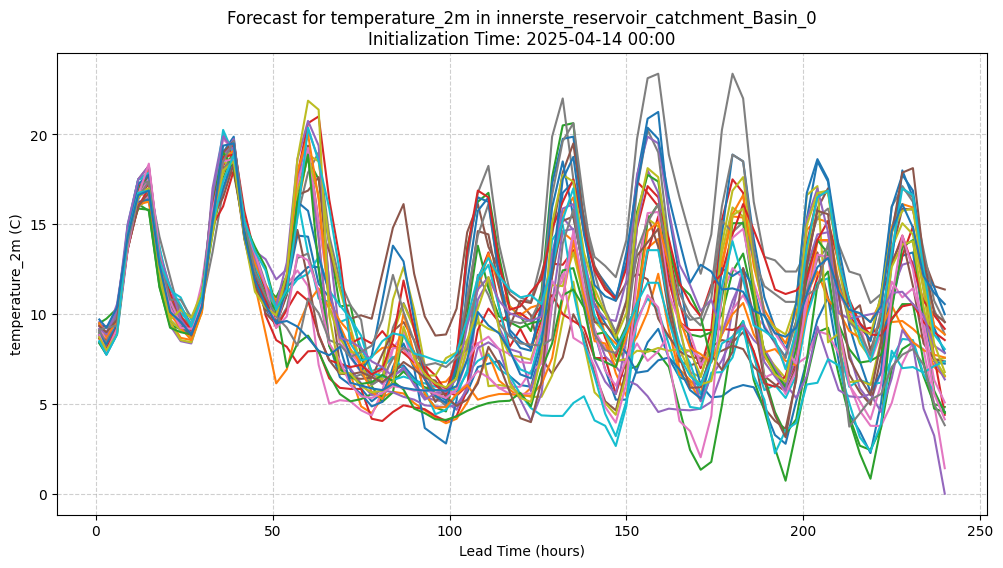

In [11]:
# Select parameters for plotting
selected_basin = basin_forecasts_hourly['basin'].values[0]  # Choose the first basin
latest_init_time = basin_forecasts_hourly['init_time'].values[-1] # Use the latest initialization time
selected_variable = 'temperature_2m'  # Choose the variable to plot

# Plot the forecast
plot_basin_forecast(basin_forecasts_hourly, selected_basin, latest_init_time, selected_variable)
plt.show() # Display the plot

Plot generated showing all ensemble members.
Plot generated for: Basin='oker_reservoir_catchment_Basin_0', Init Time='2025-04-14T00:00:00.000000000', Variable='precipitation_surface'


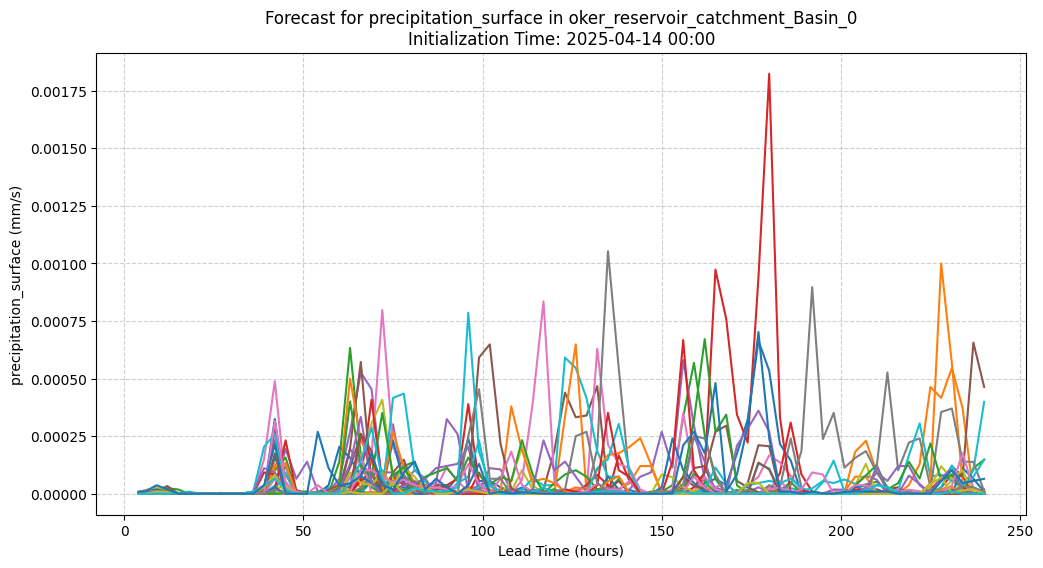

In [13]:
# Example: Plot precipitation for a different basin and the same init time
selected_basin_2 = basin_forecasts_hourly['basin'].values[1] # Choose the second basin
selected_variable_2 = 'precipitation_surface'

plot_basin_forecast(basin_forecasts_hourly, selected_basin_2, latest_init_time, selected_variable_2)
plt.show()

## Visualize Ensemble Statistics (Median and Uncertainty)

Instead of plotting all individual ensemble members, we can visualize the forecast uncertainty using quantiles. The following plot shows the median forecast (50th percentile) and a shaded area representing the range between the 5th and 95th percentiles.

Plot generated with median and [0.05, 0.95] uncertainty band.
Plot generated for: Basin='innerste_reservoir_catchment_Basin_0', Init Time='2025-04-14T00:00:00.000000000', Variable='temperature_2m'


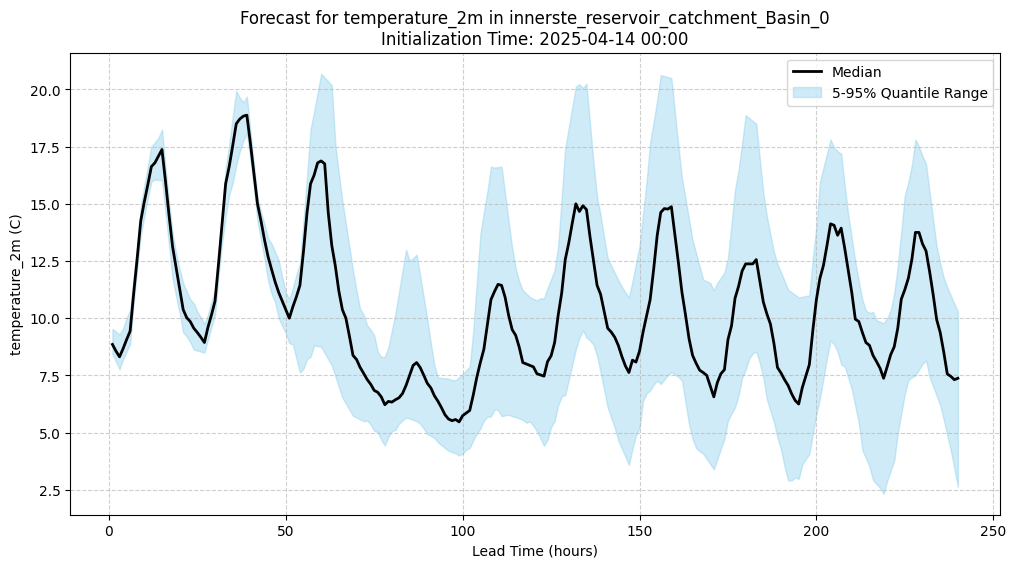

In [ ]:
# Plot temperature forecast with median and 5-95% uncertainty band
plot_basin_forecast(
    basin_forecasts_hourly, 
    selected_basin, 
    latest_init_time, 
    selected_variable, 
    uncertainty_quantiles=[0.05, 0.95], # Specify quantiles for the band
    show_members=False # Optionally hide individual members for clarity
)
plt.show()

Plot generated with median and [0.1, 0.9] uncertainty band.
Plot generated for: Basin='oker_reservoir_catchment_Basin_0', Init Time='2025-04-14T00:00:00.000000000', Variable='precipitation_surface'


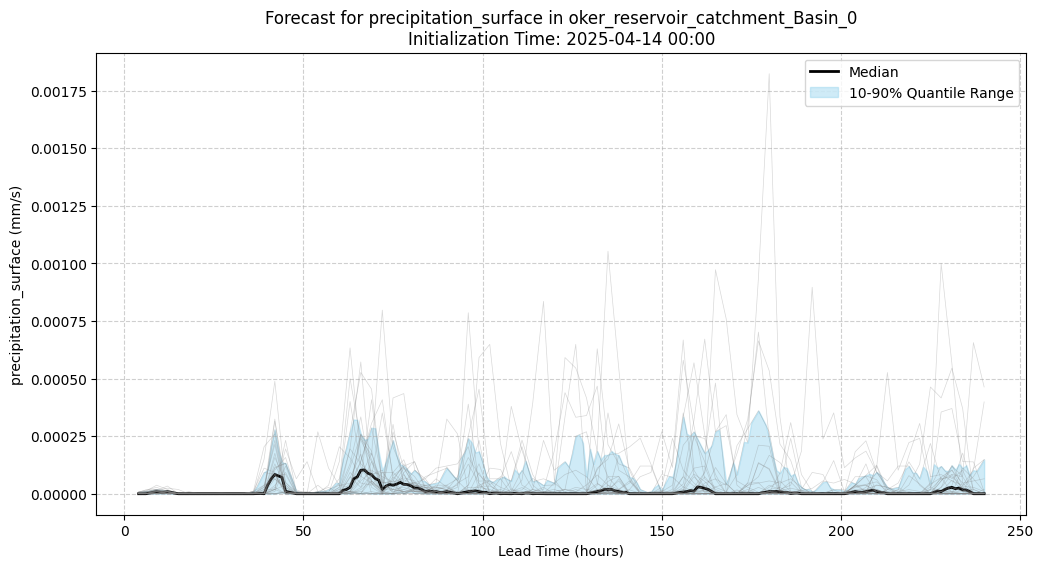

In [15]:
# Plot precipitation forecast with median, 10-90% uncertainty band, and members
plot_basin_forecast(
    basin_forecasts_hourly, 
    selected_basin_2, 
    latest_init_time, 
    selected_variable_2, 
    uncertainty_quantiles=[0.10, 0.90], # Use 10-90% range
    show_members=True # Show individual members lightly in the background
)
plt.show()